In [15]:
import sys

sys.path.append('F:/WestUS_Wateruse_SpatialDist/Codes')

import os
import numpy as np
import pandas as pd
from glob import glob
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from utils.system_ops import makedirs, copy_file
# from utils.raster_ops import read_raster_arr_object, write_array_to_raster, clip_resample_reproject_raster

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1062 entries, 0 to 1061
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1062 non-null   object  
 1   COUNTYFP  1062 non-null   object  
 2   COUNTYNS  1062 non-null   object  
 3   AFFGEOID  1062 non-null   object  
 4   GEOID     1062 non-null   object  
 5   NAME      1062 non-null   object  
 6   LSAD      1062 non-null   object  
 7   ALAND     1062 non-null   int64   
 8   AWATER    1062 non-null   int64   
 9   fips      1062 non-null   int64   
 10  area      0 non-null      object  
 11  geometry  1062 non-null   geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 99.7+ KB
None


<AxesSubplot:>

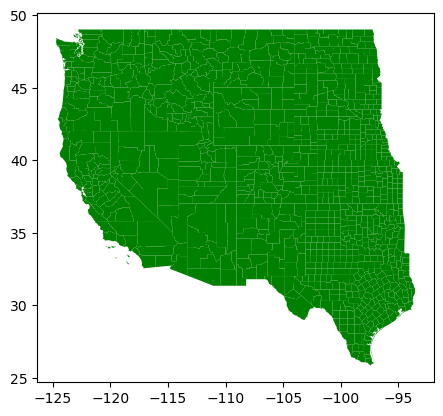

In [2]:
WestUS_county = '../../Data/shapefiles/Western_US/WestUS_county.shp'
county_df = gpd.read_file(WestUS_county)
county_df['fips'] = county_df['STATEFP'] + county_df['COUNTYFP']
county_df['fips'] = county_df['fips'].astype('int64')
print(county_df.info())
county_df.plot(facecolor='green')

In [3]:
wateruse_df = pd.read_csv('../../Data/USGS_water_use_data/WestUS_county_gw_use.csv')
wateruse_df = wateruse_df[wateruse_df['Year']==2015]
wateruse_df = wateruse_df.sort_values(by='fips', ascending=True)
wateruse_df.head()

,Name,fips,Year,total_gw_observed
1317,Apache,4001,2015,1.410900
1283,Cochise,4003,2015,20.573929
1248,Coconino,4005,2015,0.518427
1281,Gila,4007,2015,2.772069
1319,Graham,4009,2015,13.021223


In [4]:
county_df = county_df.sort_values(by='fips', ascending=True)

In [5]:
county_df = county_df.merge(wateruse_df, how='inner', on=['fips'])
county_df = county_df.sort_values(by='fips', ascending=True)  # sorting again to check values
county_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,fips,area,geometry,Name,Year,total_gw_observed
0,04,001,00025441,0500000US04001,04001,Apache,06,29001320728,54152352,4001,None,"POLYGON ((-110.00068 36.99797, -109.93414 36.9...",Apache,2015,1.410900
1,04,003,00025442,0500000US04003,04003,Cochise,06,15966170808,137020196,4003,None,"POLYGON ((-110.46072 31.55591, -110.46066 31.5...",Cochise,2015,20.573929
2,04,005,00025443,0500000US04005,04005,Coconino,06,48222143094,110123852,4005,None,"POLYGON ((-113.35413 36.04209, -113.35204 36.0...",Coconino,2015,0.518427
3,04,007,00040471,0500000US04007,04007,Gila,06,12323152727,97113523,4007,None,"POLYGON ((-111.72065 34.16270, -111.71977 34.1...",Gila,2015,2.772069
4,04,009,00025444,0500000US04009,04009,Graham,06,11972737302,47477716,4009,None,"POLYGON ((-110.45812 33.29298, -110.45719 33.2...",Graham,2015,13.021223


In [6]:
county_df.shape

(1062, 15)

<AxesSubplot:>

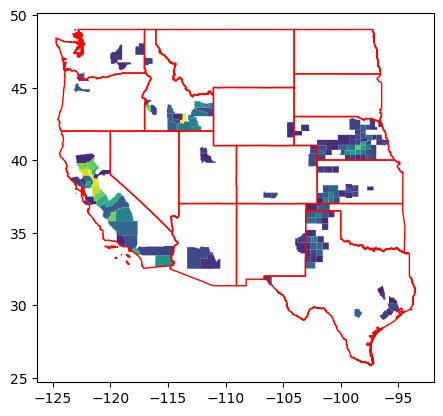

In [7]:
state_df = gpd.read_file('../../Data/shapefiles/Western_US/WestUS_states.shp')

base = county_df[county_df['total_gw_observed']>30].plot(column='total_gw_observed', vmin=0, vmax=300)
state_df.plot(ax=base, facecolor='none', edgecolor='red')

It looks like in some counties gw withdrawal has declined. It might be due to reasons like water use efficiency, regulatory change, low withdrawal due to drought, etc. To understand whether this change has been because of precipitation decrease, let's have a look at precipitation image.

#### Plotting GW use Western US 2015

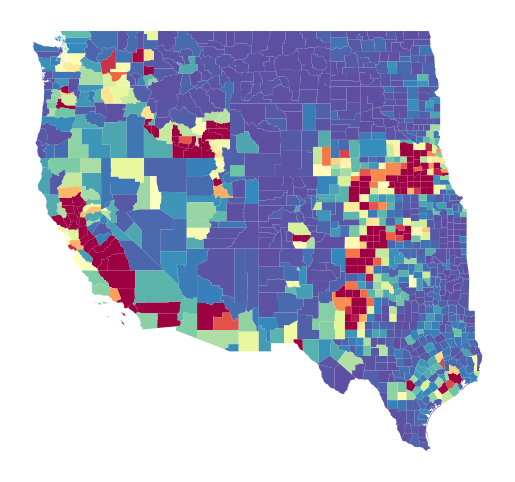

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
county_df.plot(column='total_gw_observed', vmin=0, vmax=50, cmap='Spectral_r', ax=ax)
plt.axis('off')
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\WestUS_wateruse.jpg', dpi=400)

#### Plotting a county

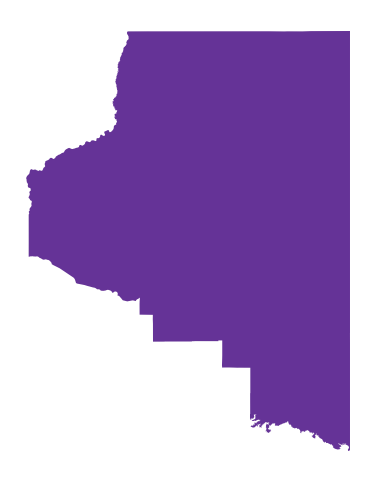

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
county_df[county_df['NAME']=='Coconino'].plot(column='total_gw_observed', cmap='Purples_r', ax=ax, alpha=0.8)
plt.axis('off')
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\Coconino_county.jpg', dpi=400)

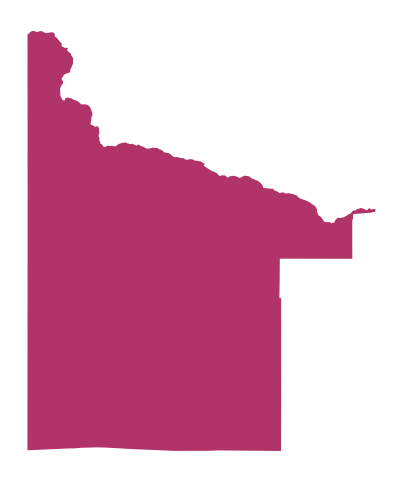

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
county_df[county_df['NAME']=='Twin Falls'].plot(column='total_gw_observed', cmap='Spectral', ax=ax, alpha=0.8)
plt.axis('off')
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\Twin_Falls_county.jpg', dpi=400)

#### Plotting RS data

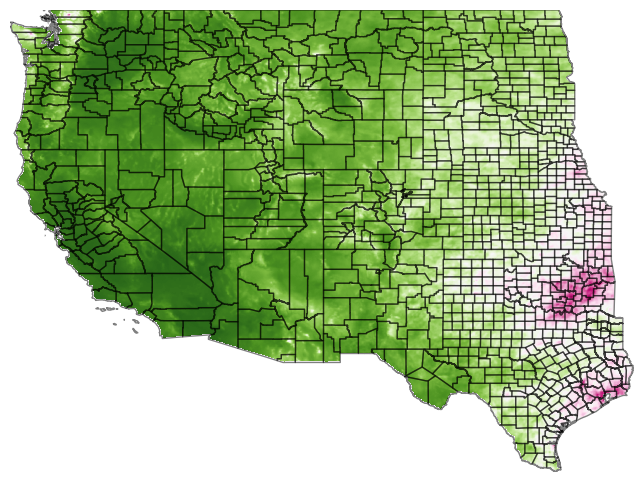

In [11]:
precip_2015 = rio.open('../../Data/Compiled_data/PRISM_PRECIP_2015.tif')

fig, ax = plt.subplots(figsize=(10, 6))
county_df.plot(facecolor='none', edgecolor='black', alpha=0.5, vmin=0, vmax=300, ax=ax)
show(precip_2015, ax=ax, cmap='PiYG_r')
plt.axis('off')
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\RS_data.png', dpi=100, transparent=True)

#### GW Use Expected Map

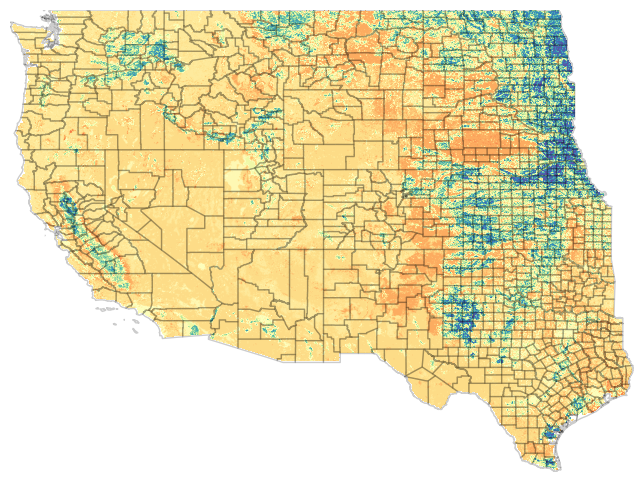

In [12]:
gw_2015 = rio.open('../../Data/GEE_data/USDA_CDL/WestUS/WestUS_2015_30m_cdls.tif') ## Using Precip as a show data for GW Use


fig, ax = plt.subplots(figsize=(10, 6))
county_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax)
show(gw_2015, ax=ax, cmap='Spectral_r')
plt.axis('off')
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\WestUS Expected Model Result.png', dpi=100, transparent=True)

#### State Map

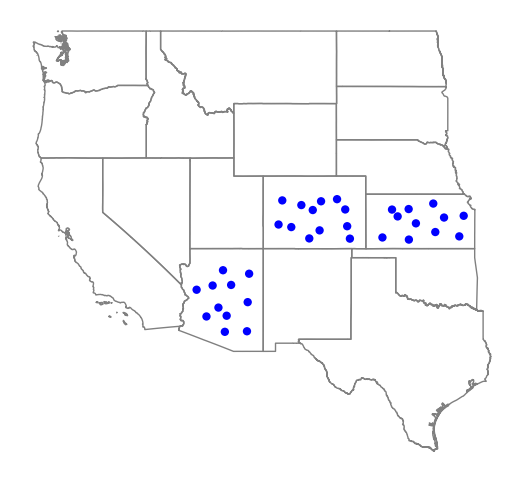

In [19]:
westUS_states = gpd.read_file('../../Data/shapefiles/Western_US/WestUS_states.shp')
false_wells = gpd.read_file(r'E:\FINESST Fellowship 2023\proposal\data and figs\pumpingwell_map_false_data.shp')

fig, ax = plt.subplots(figsize=(10, 6))
westUS_states.plot(facecolor='none', edgecolor='gray', ax=ax, label=westUS_states['NAME'])
false_wells.plot(facecolor='blue', edgecolor='none', ax=ax)
plt.axis('off')
fig.savefig('WestUS_States.png', transparent=True, dpi=200)

#### Observed ground water use data of US

In [20]:
kansas_gmd4 = pd.read_excel(r'E:\FINESST Fellowship 2023\proposal\data and figs\kansas_data\GMD4_pumping.xlsx')

In [21]:
## selecting GMD4 wells
gmd4_11 = kansas_gmd4[kansas_gmd4['PDIV_ID']==11]
gmd4_128 = kansas_gmd4[kansas_gmd4['PDIV_ID']==128]
gmd4_128

,WaterYear,PDIV_ID,long_nad83,lat_nad83,pumping [mm]
39,2008-01-01,128,-100.9987,39.66206,398.106122
40,2009-01-01,128,-100.9987,39.66206,254.558242
41,2010-01-01,128,-100.9987,39.66206,367.070968
42,2011-01-01,128,-100.9987,39.66206,444.229787
43,2012-01-01,128,-100.9987,39.66206,195.469565
44,2013-01-01,128,-100.9987,39.66206,432.619355
45,2014-01-01,128,-100.9987,39.66206,410.817391
46,2015-01-01,128,-100.9987,39.66206,128.693333
47,2016-01-01,128,-100.9987,39.66206,385.186813
48,2017-01-01,128,-100.9987,39.66206,233.680000


In [22]:
kansas_shp = gpd.read_file(r'E:\FINESST Fellowship 2023\proposal\data and figs\kansas.shp')
arizona_shp = gpd.read_file(r'E:\FINESST Fellowship 2023\proposal\data and figs\arizona.shp')
colorado_shp = gpd.read_file(r'E:\FINESST Fellowship 2023\proposal\data and figs\colorado.shp')

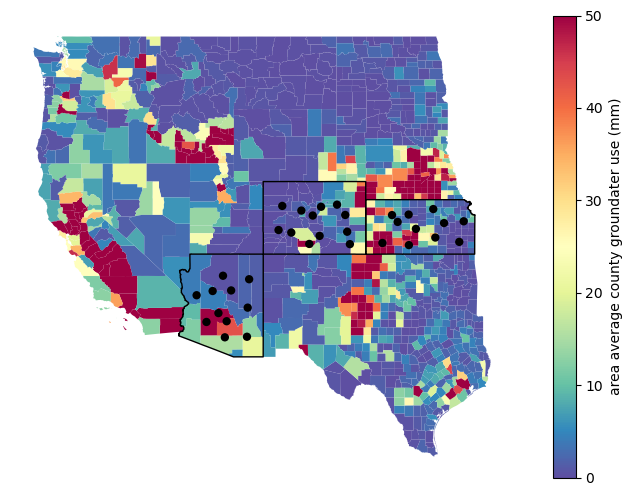

In [23]:
## County water use plot
fig, ax = plt.subplots(figsize=(10, 6))

county_gw_use = county_df.plot(column='total_gw_observed', vmin=0, vmax=50, cmap='Spectral_r', 
                               ax=ax, legend=True, 
                               legend_kwds={'label': "area average county groundater use (mm)",
                                            'orientation': "vertical"})
kansas_shp.plot(facecolor='none', edgecolor='black', ax=ax)
arizona_shp.plot(facecolor='none', edgecolor='black', ax=ax)
colorado_shp.plot(facecolor='none', edgecolor='black', ax=ax)

false_wells.plot(facecolor='black', edgecolor='none', ax=ax)
plt.axis('off')
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\WestUS_wateruse_with_colorbar_states.png', dpi=400,
           transparent=True)

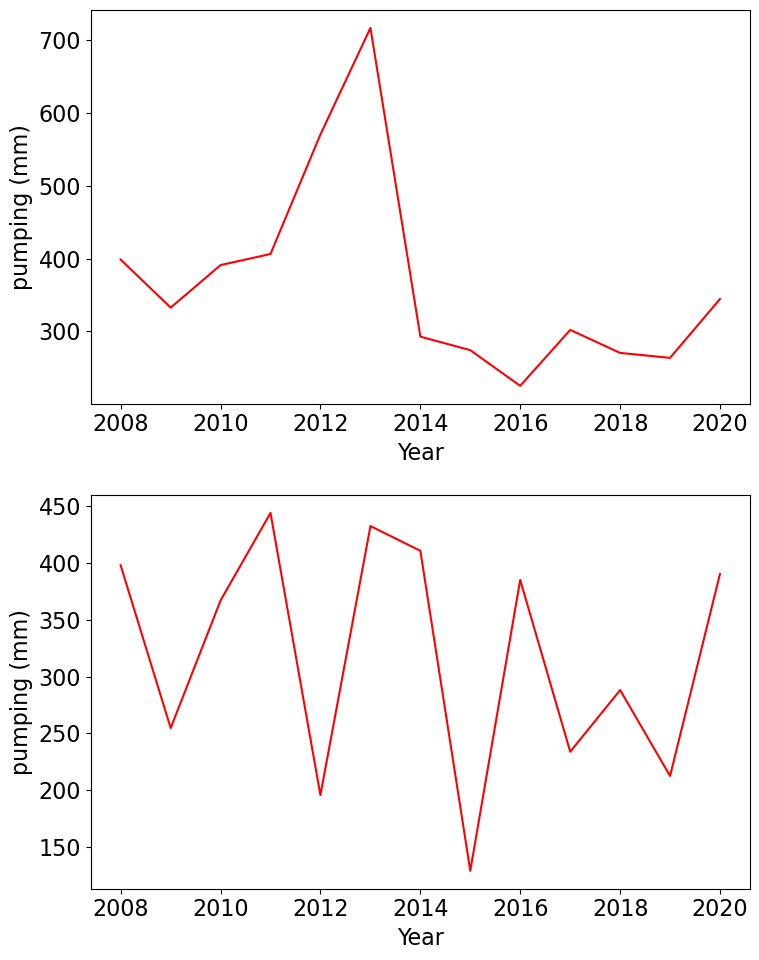

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

plt.rcParams.update({'font.size': 20})

ax[0].plot(gmd4_11['WaterYear'], gmd4_11['pumping [mm]'], color='red')

ax[0].set_xlabel('Year')
ax[0].set_ylabel('pumping (mm)')

ax[1].plot(gmd4_11['WaterYear'], gmd4_128['pumping [mm]'], color='red')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('pumping (mm)')

plt.tight_layout()
fig.savefig(r'E:\FINESST Fellowship 2023\proposal\data and figs\pumping_plots.png', dpi=400, transparent=True)

# Exploratory Data Analysis (EDA)
**to find what sources of water withdrawal in contributing to high total water withdrawal**

In [25]:
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt

In [26]:
county_WU_df = pd.read_csv('F:/WestUS_Wateruse_SpatialDist/Data_main/USGS_water_use_data/WestUS_county_WaterUse.csv')
county_WU_df.head()

,Name,fips,Year,gw_withdrawal,sw_withdrawal,total_withdrawal
0,Clallam,53009,2015,35.390659,17.265090,52.655749
1,Jefferson,53031,2015,7.601785,3.612196,11.213981
2,Grays Harbor,53027,2015,51.828722,13.729939,65.558661
3,Pacific,53049,2015,4.857541,10.714349,15.571890
4,Clatsop,41007,2015,3.480201,143.654969,147.135170


In [27]:
# Unique counties in West US
WestUS_county = list(county_WU_df['fips'].unique())
len(WestUS_county)

1062

In [28]:
county_WU_df.describe()

,fips,Year,gw_withdrawal,sw_withdrawal,total_withdrawal
count,1062.000000,1062.0,1062.000000,1062.000000,1062.000000
mean,34534.836158,2015.0,82.081245,291.430172,373.511417
std,14923.778133,0.0,166.444758,2344.950088,2350.464352
min,4001.000000,2015.0,0.000000,0.000000,0.046467
25%,20169.500000,2015.0,4.714969,1.271582,18.477559
50%,38092.000000,2015.0,26.258238,18.923594,78.697290
75%,48158.500000,2015.0,90.566211,183.943854,345.501789
max,56045.000000,2015.0,2421.366748,73809.023918,73840.563241


### Investigating high water withdrawal counties 

### Total Water

In [29]:
high_totalW_county = county_WU_df[county_WU_df['total_withdrawal'] > 1.5 *345] #2000
print(len(high_totalW_county))
high_totalW_county = high_totalW_county.sort_values(by='total_withdrawal', ascending=False)
high_totalW_county.head(30)

196


,Name,fips,Year,gw_withdrawal,sw_withdrawal,total_withdrawal
787,Somervell,48425,2015,31.539323,73809.023918,73840.563241
1019,Titus,48449,2015,7.268321,11590.376623,11597.644945
351,Jackson,8057,2015,4.983992,5339.879900,5344.863891
1040,Rusk,48401,2015,43.745107,5180.118867,5223.863974
315,Pitkin,8097,2015,50.062417,5009.445697,5059.508114
939,Freestone,48161,2015,30.223047,4766.147235,4796.370282
316,Gunnison,8051,2015,35.703338,4351.189700,4386.893038
320,Hinsdale,8053,2015,81.301365,4031.426318,4112.727684
312,Carbon,56007,2015,28.441913,4050.282085,4078.723998
942,Robertson,48395,2015,182.263607,3815.884857,3998.148464


In [30]:
# my sorted counties from Random Forest
list_highTW = high_totalW_county.head(30)['fips'].to_list()
list_highTW

[48425,
 48449,
 8057,
 48401,
 8097,
 48161,
 8051,
 8053,
 56007,
 48395,
 48175,
 48373,
 8091,
 32011,
 6091,
 16047,
 56001,
 48073,
 30001,
 16083,
 49033,
 30081,
 8077,
 35061,
 8067,
 41029,
 8085,
 35053,
 8105,
 16035]

### Surface Water

In [31]:
high_SW_county = county_WU_df[county_WU_df['sw_withdrawal'] > (1.5 *183)]
high_SW_county = high_SW_county.sort_values(by='sw_withdrawal', ascending=False)
high_SW_county.head(30)

,Name,fips,Year,gw_withdrawal,sw_withdrawal,total_withdrawal
787,Somervell,48425,2015,31.539323,73809.023918,73840.563241
1019,Titus,48449,2015,7.268321,11590.376623,11597.644945
351,Jackson,8057,2015,4.983992,5339.879900,5344.863891
1040,Rusk,48401,2015,43.745107,5180.118867,5223.863974
315,Pitkin,8097,2015,50.062417,5009.445697,5059.508114
939,Freestone,48161,2015,30.223047,4766.147235,4796.370282
316,Gunnison,8051,2015,35.703338,4351.189700,4386.893038
312,Carbon,56007,2015,28.441913,4050.282085,4078.723998
320,Hinsdale,8053,2015,81.301365,4031.426318,4112.727684
942,Robertson,48395,2015,182.263607,3815.884857,3998.148464


In [32]:
# checking if high total water use "my list" counyites are also using high surface water
high_sw_coutnies_selected = []
for i in list_highTW:
    if i in list(high_SW_county['fips']):
        high_sw_coutnies_selected.append(i)

print('In these counties high total water and sw use has been reported')
sorted(high_sw_coutnies_selected)
print(len(high_sw_coutnies_selected))

In these counties high total water and sw use has been reported
29


### Ground Water

In [33]:
high_GW_county = county_WU_df[county_WU_df['gw_withdrawal'] > (1.5 *90)]
high_GW_county = high_GW_county.sort_values(by='gw_withdrawal', ascending=False)
high_GW_county.head(15)

,Name,fips,Year,gw_withdrawal,sw_withdrawal,total_withdrawal
147,Eureka,32011,2015,2421.366748,27.059825,2448.426572
47,Sierra,6091,2015,1617.616819,657.886910,2275.503729
129,Esmeralda,32009,2015,1366.576553,0.000000,1366.576553
148,White Pine,32033,2015,1320.956038,129.215649,1450.171687
569,Hooker,31091,2015,1157.843581,75.694375,1233.537956
447,Pecos,48371,2015,1069.495592,20.306399,1089.801991
127,Lander,32015,2015,1033.648737,64.410306,1098.059043
149,Lincoln,32017,2015,1017.143158,46.082455,1063.225613
33,Plumas,6063,2015,920.034040,383.347517,1303.381557
130,Imperial,6025,2015,818.669827,360.716402,1179.386229


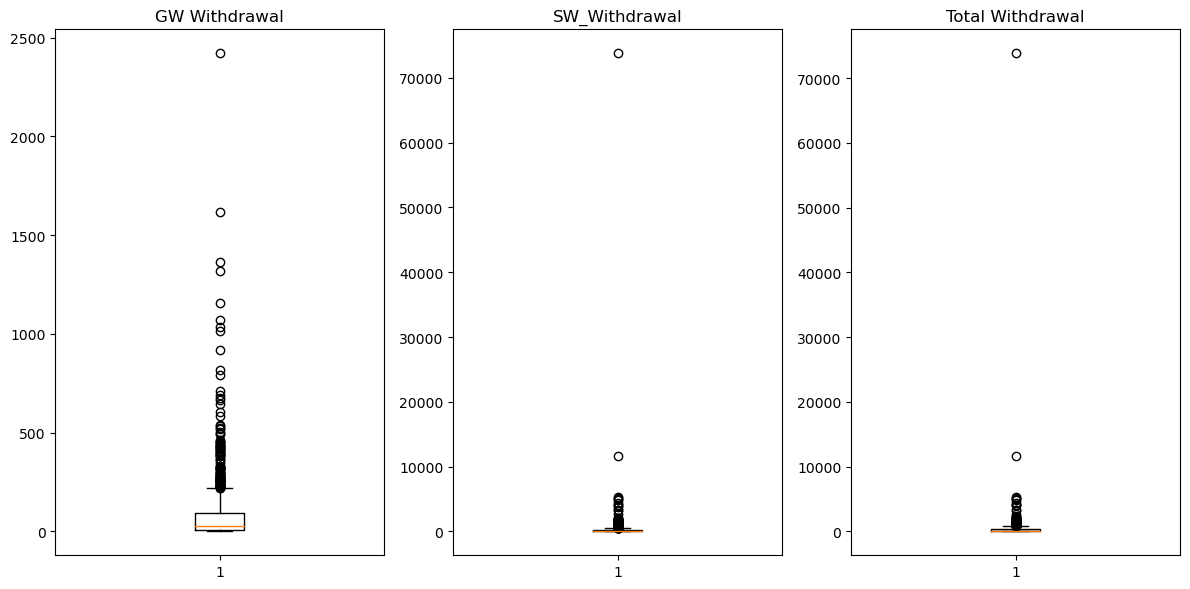

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].boxplot(county_WU_df['gw_withdrawal'])
axs[0].set_title('GW Withdrawal')
axs[1].boxplot(county_WU_df['sw_withdrawal'])
axs[1].set_title('SW_Withdrawal')
axs[2].boxplot(county_WU_df['total_withdrawal'])
axs[2].set_title('Total Withdrawal')
plt.tight_layout()
plt.show()

```Presence of outliers make it difficult to see the boxplots.```

## Investigating USGS County Level Data
__to find the source of high water withdrawal__


In [35]:
usgs_df = pd.read_excel(r'F:\WestUS_Wateruse_SpatialDist\Data_main\USGS_water_use_data\usco2015.xlsx')
usgs_df.head() 

C:\Users\fahim\Anaconda3\envs\US_wateruse\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,STATE,STATEFIPS,COUNTY,COUNTYFIPS,FIPS,YEAR,TP-TotPop,PS-GWPop,PS-SWPop,PS-TOPop,...,TO-WGWTo,TO-WSWFr,TO-WSWSa,TO-WSWTo,TO-WFrTo,TO-WSaTo,TO-Wtotl,TO-CUsFrPartial,TO-CUsSaPartial,TO-CUTotPartial
0,AL,1,Autauga County,1,1001,2015,55.347,--,--,48.998,...,10.69,45.72,0.0,45.72,56.41,0.0,56.41,13.18,0.0,13.18
1,AL,1,Baldwin County,3,1003,2015,203.709,--,--,174.907,...,73.38,11.32,0.0,11.32,84.70,0.0,84.70,58.28,0.0,58.28
2,AL,1,Barbour County,5,1005,2015,26.489,--,--,24.587,...,6.06,2.96,0.0,2.96,9.02,0.0,9.02,2.96,0.0,2.96
3,AL,1,Bibb County,7,1007,2015,22.583,--,--,20.947,...,5.67,0.20,0.0,0.20,5.87,0.0,5.87,0.19,0.0,0.19
4,AL,1,Blount County,9,1009,2015,57.673,--,--,44.815,...,4.64,55.43,0.0,55.43,60.07,0.0,60.07,1.08,0.0,1.08


In [36]:
usgs_WestUS_df = usgs_df[usgs_df['FIPS'].isin(WestUS_county)]
len(usgs_WestUS_df)

1062

In [37]:
# Available Columns
usgs_WestUS_df.columns

Index(['STATE', 'STATEFIPS', 'COUNTY', 'COUNTYFIPS', 'FIPS', 'YEAR',
       'TP-TotPop', 'PS-GWPop', 'PS-SWPop', 'PS-TOPop',
       ...
       'TO-WGWTo', 'TO-WSWFr', 'TO-WSWSa', 'TO-WSWTo', 'TO-WFrTo', 'TO-WSaTo',
       'TO-Wtotl', 'TO-CUsFrPartial', 'TO-CUsSaPartial', 'TO-CUTotPartial'],
      dtype='object', length=141)

#### Making a list of columns of surface water withdrawal source

In [38]:
sw_source_list = ['PS-WSWFr', 'DO-WSWFr', 'IN-WSWFr', 'IR-WSWFr', 'IC-WSWFr', 'IG-WSWFr', 'LI-WSWFr', 'AQ-WSWFr',
                  'MI-WSWFr', 'PT-WSWFr', 'PO-WSWFr', 'PC-WSWFr', 'TO-WSWFr']

#### Colum detail
- PS-WSWFr - Public Supply, surface-water withdrawals, fresh, in Mgal/d
- DO-WSWFr - Domestic, self-supplied surface-water withdrawals, fresh, in Mgal/d
- IN-WSWFr - Industrial, self-supplied surface-water withdrawals, fresh, in Mgal/d
- IR-WSWFr - Irrigation, surface-water withdrawals, fresh, in Mgal/d
- IC-WSWFr - Irrigation-Crop, surface-water withdrawals, fresh, in Mgal/d
- IG-WSWFr - Irrigation-Golf, surface-water withdrawals, fresh, in Mgal/d
- LI-WSWFr - Livestock, surface-water withdrawals, fresh, in Mgal/d
- AQ-WSWFr - Aquaculture, surface-water withdrawals, fresh, in Mgal/d
- MI-WSWFr - Mining, surface-water withdrawals, fresh, in Mgal/d
- PT-WSWFr - Thermoelectric, surface-water withdrawals, fresh, in Mgal/d
- PO-WSWFr - Thermoelectric once-through, surface-water withdrawals, fresh, in Mgal/d
- PC-WSWFr - Thermoelectric recirculating, surface-water withdrawals, fresh, in Mgal/d
- TO-WSWFr - Total surface-water withdrawals, fresh, in Mgal/d


In [39]:
selected_county_df = usgs_WestUS_df[usgs_WestUS_df['FIPS'].isin(list_highTW)]

In [40]:
sw_source_list.append('FIPS')

In [42]:
selected_SW_df = selected_county_df[sw_source_list]
selected_SW_df = selected_SW_df.sort_values(by='TO-WSWFr', ascending=False)
selected_SW_df.head()

,PS-WSWFr,DO-WSWFr,IN-WSWFr,IR-WSWFr,IC-WSWFr,IG-WSWFr,LI-WSWFr,AQ-WSWFr,MI-WSWFr,PT-WSWFr,PO-WSWFr,PC-WSWFr,TO-WSWFr,FIPS
2735,0.97,0.0,0.00,0.00,--,--,0.08,0.00,0.00,2105.15,2105.15,0.0,2106.20,48425
592,0.00,0.0,0.17,988.75,988.75,0,0.50,653.69,0.02,0.00,0.00,0.0,1643.13,16083
2747,5.31,0.0,0.00,1.03,--,--,2.04,0.03,0.57,1107.27,1107.27,0.0,1116.25,48449
2720,0.09,0.0,0.00,1.25,--,--,1.68,0.00,0.02,1045.02,1045.02,0.0,1048.06,48395
574,0.00,0.0,0.00,306.03,306.03,0,0.52,675.13,0.06,0.00,0.00,0.0,981.74,16047


In [43]:
# Checking data type
selected_SW_df.dtypes

PS-WSWFr    float64
DO-WSWFr    float64
IN-WSWFr    float64
IR-WSWFr    float64
IC-WSWFr     object
IG-WSWFr     object
LI-WSWFr    float64
AQ-WSWFr    float64
MI-WSWFr    float64
PT-WSWFr    float64
PO-WSWFr    float64
PC-WSWFr    float64
TO-WSWFr    float64
FIPS          int64
dtype: object

In [44]:
# Checking if the considered sources are the only sources of Surface water total withdrawal
selected_SW_df['calc_total_sw'] = selected_SW_df['PS-WSWFr'] + selected_SW_df['DO-WSWFr'] + selected_SW_df['IN-WSWFr'] +\
    selected_SW_df['IR-WSWFr'] + selected_SW_df['LI-WSWFr'] + selected_SW_df['AQ-WSWFr'] + selected_SW_df['MI-WSWFr'] + \
    selected_SW_df['PT-WSWFr']
    
selected_SW_df

,PS-WSWFr,DO-WSWFr,IN-WSWFr,IR-WSWFr,IC-WSWFr,IG-WSWFr,LI-WSWFr,AQ-WSWFr,MI-WSWFr,PT-WSWFr,PO-WSWFr,PC-WSWFr,TO-WSWFr,FIPS,calc_total_sw
2735,0.97,0.00,0.00,0.00,--,--,0.08,0.00,0.00,2105.15,2105.15,0.00,2106.20,48425,2106.20
592,0.00,0.00,0.17,988.75,988.75,0,0.50,653.69,0.02,0.00,0.00,0.00,1643.13,16083,1643.13
2747,5.31,0.00,0.00,1.03,--,--,2.04,0.03,0.57,1107.27,1107.27,0.00,1116.25,48449,1116.25
2720,0.09,0.00,0.00,1.25,--,--,1.68,0.00,0.02,1045.02,1045.02,0.00,1048.06,48395,1048.06
574,0.00,0.00,0.00,306.03,306.03,0,0.52,675.13,0.06,0.00,0.00,0.00,981.74,16047,981.74
2723,0.74,0.00,0.00,0.00,--,--,1.21,0.01,0.48,976.86,974.13,2.73,979.30,48401,979.30
3122,1.16,0.00,0.28,893.43,--,--,0.79,0.07,0.00,0.00,0.00,0.00,895.73,56007,895.73
283,17.47,0.00,1.72,756.93,755.2,1.73,0.28,73.26,0.00,0.00,0.00,0.00,849.66,8077,849.66
1598,0.00,0.00,0.01,831.17,--,--,1.31,0.00,0.08,0.00,0.00,0.00,832.57,30001,832.57
2603,0.00,0.00,0.00,0.00,--,--,0.93,0.00,0.00,696.10,692.44,3.66,697.03,48161,697.03


**The sources considered in the ```calc_total_sw``` are the only sources of surface water.**

In [53]:
high_irrig_counties = selected_SW_df.sort_values(by='IR-WSWFr', ascending=False)
high_irrig_counties.head(23)

,PS-WSWFr,DO-WSWFr,IN-WSWFr,IR-WSWFr,IC-WSWFr,IG-WSWFr,LI-WSWFr,AQ-WSWFr,MI-WSWFr,PT-WSWFr,PO-WSWFr,PC-WSWFr,TO-WSWFr,FIPS,calc_total_sw
592,0.00,0.00,0.17,988.75,988.75,0,0.50,653.69,0.02,0.00,0.00,0.00,1643.13,16083,1643.13
3122,1.16,0.00,0.28,893.43,--,--,0.79,0.07,0.00,0.00,0.00,0.00,895.73,56007,895.73
1598,0.00,0.00,0.01,831.17,--,--,1.31,0.00,0.08,0.00,0.00,0.00,832.57,30001,832.57
283,17.47,0.00,1.72,756.93,755.2,1.73,0.28,73.26,0.00,0.00,0.00,0.00,849.66,8077,849.66
287,9.13,0.00,0.00,671.64,670.56,1.08,0.31,10.80,0.03,0.96,0.00,0.96,692.87,8085,692.87
3119,3.16,0.00,0.08,529.05,--,--,0.48,1.34,0.00,0.00,0.00,0.00,534.11,56001,534.11
270,0.66,0.00,0.00,520.53,520.24,0.29,0.20,6.06,0.25,0.00,0.00,0.00,527.70,8051,527.70
297,0.00,0.00,0.00,455.36,455.22,0.14,0.10,0.00,0.00,0.00,0.00,0.00,455.46,8105,455.46
1638,0.27,0.00,0.00,379.08,--,--,0.42,0.87,0.06,0.00,0.00,0.00,380.70,30081,380.70
273,0.16,0.00,0.00,340.40,340.4,0,0.14,2.15,0.00,0.00,0.00,0.00,342.85,8057,342.85


In [48]:
high_irrig_counties['FIPS'][:15].to_list()

[16083,
 56007,
 30001,
 8077,
 8085,
 56001,
 8051,
 8105,
 30081,
 8057,
 41029,
 8067,
 16047,
 35061,
 8097]

In [55]:
high_thermo_counties = selected_SW_df.sort_values(by='PT-WSWFr', ascending=False)
high_thermo_counties.head(10)

,PS-WSWFr,DO-WSWFr,IN-WSWFr,IR-WSWFr,IC-WSWFr,IG-WSWFr,LI-WSWFr,AQ-WSWFr,MI-WSWFr,PT-WSWFr,PO-WSWFr,PC-WSWFr,TO-WSWFr,FIPS,calc_total_sw
2735,0.97,0.00,0.0,0.00,--,--,0.08,0.00,0.00,2105.15,2105.15,0.00,2106.20,48425,2106.20
2747,5.31,0.00,0.0,1.03,--,--,2.04,0.03,0.57,1107.27,1107.27,0.00,1116.25,48449,1116.25
2720,0.09,0.00,0.0,1.25,--,--,1.68,0.00,0.02,1045.02,1045.02,0.00,1048.06,48395,1048.06
2723,0.74,0.00,0.0,0.00,--,--,1.21,0.01,0.48,976.86,974.13,2.73,979.30,48401,979.30
2603,0.00,0.00,0.0,0.00,--,--,0.93,0.00,0.00,696.10,692.44,3.66,697.03,48161,697.03
2559,0.84,0.00,0.0,0.16,--,--,1.33,0.00,0.02,367.76,367.76,0.00,370.11,48073,370.11
2610,0.00,0.00,0.0,0.00,--,--,0.13,0.00,0.00,280.88,280.88,0.00,281.01,48175,281.01
287,9.13,0.00,0.0,671.64,670.56,1.08,0.31,10.80,0.03,0.96,0.00,0.96,692.87,8085,692.87
231,0.05,0.01,0.0,6.90,6.9,0,0.08,0.00,0.00,0.00,0.00,0.00,7.04,6091,7.04
271,0.00,0.00,0.0,20.24,20.24,0,0.02,8.50,0.00,0.00,0.00,0.00,28.76,8053,28.76


In [56]:
high_thermo_counties['FIPS'][:7].to_list()

[48425, 48449, 48395, 48401, 48161, 48073, 48175]